# UNET 图像语义分割（UNET Image Semantic Segmentation）

## 图像语义分割
图像语义分割是计算机视觉中十分重要的领域，它是指像素级地识别图像，即标注出图像中每个像素所属的对象类别（如属于背景、边缘或身体等）。

与实例分割的区分，语义分割没有分离同一类的实例，只关心图像中每个像素所属的类别，如果输入对象中有两个相同类别的对象，则语义分割本身不将他们区分为单独的对象。

**图像语义分割的应用场景：**
1. 自动驾驶：自动驾驶汽车需要理解道路、车辆、行人等对象，从而做出正确的决策。
2. 医学图像处理：医学图像处理中，语义分割可以用于识别器官、肿瘤等。
3. 机器人视觉：机器人需要理解环境，从而做出正确的决策。
4. 无人机：无人机需要理解环境，从而做出正确的决策。

**语义分割的目标：**
一般是将一张RGB图像（height * width * 3）或是一张灰度图像（height * width * 1）作为输入，输出一张与输入图像大小相同的分割图（height * width * 1），其中每个像素的值代表该像素所属的类别。

**图像语义分割的实现：**
目前在图像分割领域比较成功的算法，有很大一部分来自于同一个先驱：Long等人提出的Fully Convolutional Networks (FCN)，或者叫全卷积网络。FCN将分类网络转化成用于分隔任务的网络结构，并证明了在分割问题上，卷积层和池化层可以替代全连接层，从而使得网络可以接受任意尺寸的输入图像，并输出对应尺寸的分割图。FCN成为了深度学习解决分割问题的奠基石。

## 语义分割的UNET网络结构
Unet是2015年诞生的模型，他几乎是语义分割领域的标准模型，Unet能从更少的训练图像中进行学习。当他在少于40张图的生物医学数据集上训练时，IOU值仍然能达到92%。

Unet已经成为大多数医疗影像语义分割任务最基础的网络结构，即使在自然影像理解方面，也有越来越多的语义分割和目标检测研究开始使用Unet作为基础网络结构。

U-net网络前半部分的作用是特征提取，后半部分是上采样，在一些文献中也把这样的结构叫做编码器-解码器结构。由于此网络整体结构类似于字母U，故得名U-net。


## UNet网络结构

![U-Net.png](./imgs/U-Net.png)

- 输入和输出
  - 输入可以是任意尺寸的彩色图像
  - 输出与输入尺寸相同通道数为：n（目标类别数） + 1（背景）
- 全卷积
  - 网络在CNN卷积部分不用全连接层，而是用卷积层代替，这样网络可以接受任意尺寸的输入图像，并输出对应尺寸的分割图。
- 上采样Upsampling
  - 由于在卷积过程中，图像尺寸会缩小，为了得到原图像大小的稠密像素预测，因此需要上采样恢复图像尺寸，常见的上采样方法有反卷积（转置卷积）、插值、反池化等。
- IOU评价指标
  - IOU（Intersection over Union）也可以叫做交并比，是一种测量在特定数据集中检测相应物体准确度的一个标准。
  - 只要是在输出中得到一个预测范围（bounding boxex）的任务，都可以使用IOU来衡量预测的准确度，比如目标检测、语义分割等。
  - IOU表示产生的候选框（candidate bound）与原标记框（ground truth bound）的交集和并集的比值，其值介于0和1之间，值越接近1表示模型的预测效果越好。
  - IOU = area(intersection) / area(union)

## 导入库

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torchvision
from torchvision import transforms
import os

import glob
from PIL import Image

## 观察数据

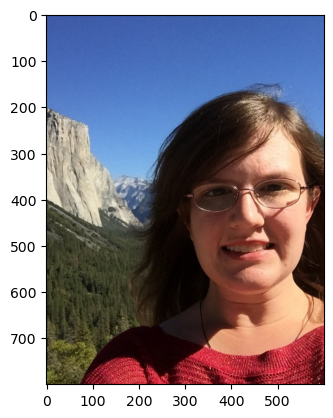

In [2]:
# 打开一张数据图片
pil_img = Image.open(r'.\dataset\hk\training\00001.png')
# 转换为numpy数组
np_img = np.array(pil_img)
plt.imshow(np_img)
plt.show()

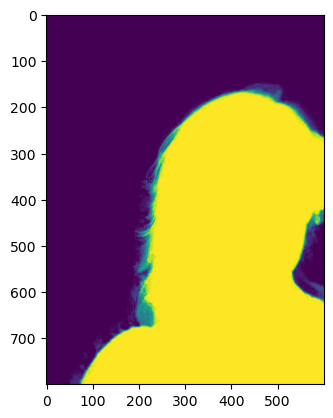

In [3]:
# 打开一张数据图片的标注（这里为蒙版）
pil_img = Image.open(r'.\dataset\hk\training\00001_matte.png')
# 转换为numpy数组
np_img = np.array(pil_img)
plt.imshow(np_img)
plt.show()

In [4]:
# 查看标注的像素取值
np.unique(np_img)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [5]:
# 查看标注的像素取值范围
print("Max: {}, Min: {}".format(np_img.max(), np_img.min()))
# 查看标注的形状
print("Shape: {}".format(np_img.shape))

Max: 255, Min: 0
Shape: (800, 600)


In [6]:
# 将标注的像素值大于0的像素点置为1
np_img[np_img > 0] = 1
print("Max: {}, Min: {}".format(np_img.max(), np_img.min()))

Max: 1, Min: 0


## 数据预处理

In [7]:
# 获取所有数据图片路径
all_pics = glob.glob(r'.\dataset\hk\training\*.png')
# 查看数据图片路径
all_pics[:5]

['.\\dataset\\hk\\training\\00001.png',
 '.\\dataset\\hk\\training\\00001_matte.png',
 '.\\dataset\\hk\\training\\00002.png',
 '.\\dataset\\hk\\training\\00002_matte.png',
 '.\\dataset\\hk\\training\\00003.png']

In [8]:
# 从所有数据图片路径中筛选出数据图片
images = [p for p in all_pics if 'matte' not in p]
# 查看数据图片数量
print("Total images: {}".format(len(images)))
images[:5]

Total images: 1700


['.\\dataset\\hk\\training\\00001.png',
 '.\\dataset\\hk\\training\\00002.png',
 '.\\dataset\\hk\\training\\00003.png',
 '.\\dataset\\hk\\training\\00004.png',
 '.\\dataset\\hk\\training\\00005.png']

In [9]:
# 从所有数据图片路径中筛选出数据图片的标注
annos = [p for p in all_pics if 'matte' in p]
# 查看数据图片标注数量
print("Total annotations: {}".format(len(annos)))
images[:5]

Total annotations: 1700


['.\\dataset\\hk\\training\\00001.png',
 '.\\dataset\\hk\\training\\00002.png',
 '.\\dataset\\hk\\training\\00003.png',
 '.\\dataset\\hk\\training\\00004.png',
 '.\\dataset\\hk\\training\\00005.png']

In [10]:
np.random.seed(2021)        # 随机种子，保证每次划分结果一致
random_index = np.random.permutation(len(images))      # 创建与数据集等长的乱序索引random_index
# 对图片使用random_index进行索引
images = np.array(images)[random_index]
# 对标签使用random_index进行索引
annos = np.array(annos)[random_index]
images[:5], annos[:5]

(array(['.\\dataset\\hk\\training\\00372.png',
        '.\\dataset\\hk\\training\\01290.png',
        '.\\dataset\\hk\\training\\00063.png',
        '.\\dataset\\hk\\training\\01131.png',
        '.\\dataset\\hk\\training\\01126.png'], dtype='<U31'),
 array(['.\\dataset\\hk\\training\\00372_matte.png',
        '.\\dataset\\hk\\training\\01290_matte.png',
        '.\\dataset\\hk\\training\\00063_matte.png',
        '.\\dataset\\hk\\training\\01131_matte.png',
        '.\\dataset\\hk\\training\\01126_matte.png'], dtype='<U37'))

In [11]:
# 预处理测试集
all_test_pics = glob.glob(r'.\dataset\hk\testing\*.png')
test_images = [p for p in all_test_pics if 'matte' not in p]
test_annos = [p for p in all_test_pics if 'matte' in p]

# 创建数据集

In [12]:
# 图片变换
transform = transforms.Compose([
                    transforms.Resize((256, 256)),
                    transforms.ToTensor(),
])

In [13]:
# 自定义数据集类
class Portrait_dataset(data.Dataset):
    def __init__(self, img_paths, anno_paths):
        self.imgs = img_paths
        self.annos = anno_paths
        
    def __getitem__(self, index):
        img = self.imgs[index]
        anno = self.annos[index]
        
        pil_img = Image.open(img)    
        img_tensor = transform(pil_img)
        
        pil_anno = Image.open(anno)    
        anno_tensor = transform(pil_anno)
        anno_tensor = torch.squeeze(anno_tensor).type(torch.long)   # 去掉标注中为1的维度，并将标注转换为long类型
        anno_tensor[anno_tensor > 0] = 1
        
        return img_tensor, anno_tensor
    
    def __len__(self):
        return len(self.imgs)

In [14]:
# 实例化划分后的数据集
train_ds = Portrait_dataset(images, annos)
test_ds = Portrait_dataset(test_images, test_annos)

BATCH_SIZE = 32

train_dl = data.DataLoader(dataset=train_ds,
                           batch_size=BATCH_SIZE,
                           shuffle=True,
                           pin_memory=True
)
test_dl = data.DataLoader(dataset=test_ds,
                          batch_size=BATCH_SIZE,
                          pin_memory=True
)

Image shape: torch.Size([32, 3, 256, 256])
Annotation shape: torch.Size([32, 256, 256])


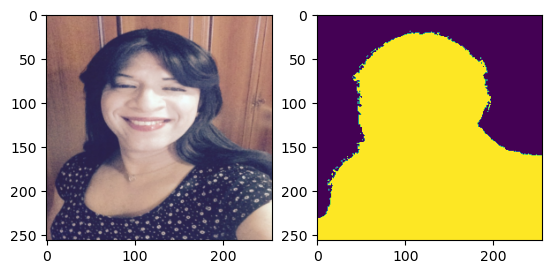

In [15]:
# 取出一个batch的图片和标签
imgs_batch, annos_batch = next(iter(train_dl))

# 查看图片和标签的形状
print("Image shape: {}".format(imgs_batch.shape))
print("Annotation shape: {}".format(annos_batch.shape))

# 图片转换为numpy数组
img = imgs_batch[0].permute(1,2,0).numpy()      # 将tensor数据转化为numpy数据
anno = annos_batch[0].numpy()

# 显示图片和标签
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(anno)

# 定义网络结构

In [16]:
# 下采样模型
class Downsample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Downsample, self).__init__()
        # 卷积层（两层 卷积 + 激活）
        self.conv_relu = nn.Sequential(
                            nn.Conv2d(in_channels=in_channels,
                                      out_channels=out_channels, 
                                      kernel_size=3,
                                      padding=1),       # kernel_size=3时，令padding=1，保证卷积后图片尺寸不变，与原论文略有不同
                            nn.ReLU(inplace=True),
                            nn.Conv2d(in_channels=out_channels,
                                      out_channels=out_channels,
                                      kernel_size=3,
                                      padding=1),       # kernel_size=3时，令padding=1，保证卷积后图片尺寸不变，与原论文略有不同
                            nn.ReLU(inplace=True)
            )
        # 最大池化（下采样）
        self.pool = nn.MaxPool2d(kernel_size=2)
    
    def forward(self, x, is_pool=True):
        if is_pool:
            x = self.pool(x)
        x = self.conv_relu(x)
        return x

In [17]:
# 上采样模型
class Upsample(nn.Module):
    def __init__(self, channels):       # 输入通道数定义为第二层卷积的通道数
        super(Upsample, self).__init__()
        # 卷积层（两层 卷积 + 激活）
        self.conv_relu = nn.Sequential(
                            nn.Conv2d(in_channels=2*channels,       # 第一层卷积的通道数为2倍，因为需要将下采样后的特征图与上采样后的特征图进行拼接
                                      out_channels=channels,
                                      kernel_size=3,
                                      padding=1),
                            nn.ReLU(inplace=True),
                            nn.Conv2d(in_channels=channels,
                                      out_channels=channels,
                                      kernel_size=3,
                                      padding=1),
                            nn.ReLU(inplace=True)
            )
        # 反卷积（上采样）
        self.upconv_relu = nn.Sequential(
                                # 反卷积
                                nn.ConvTranspose2d(in_channels=channels, 
                                                   out_channels=channels//2, # 上采样后的通道数为原来的一半，与下采样时卷积的通道数相对应
                                                   kernel_size=3,      # 卷积核大小，与原始论文中2*2的卷积核不同，这里使用3*3的卷积核
                                                   stride=2,           # 上采样倍数，stride=2，与下采样时池化操作的kernel_size=2相对应
                                                   padding=1,          # 与卷积中的padding不同，表示卷积核初始位置与输入图像边缘的空隙
                                                   output_padding=1),  # 表示反卷积后图像边缘向外扩展的像素数
                                nn.ReLU(inplace=True)
            )
    
    def forward(self, x, is_conv=True):
        if is_conv:
            x = self.conv_relu(x)
        x = self.upconv_relu(x)
        return x

In [18]:
# 定义网络
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        # 初始卷积层
        self.conv_1 = Downsample(3, 64)        # 没有池化层，直接卷积
        # 下采样（四层）
        self.down1 = Downsample(64, 128)
        self.down2 = Downsample(128, 256)
        self.down3 = Downsample(256, 512)
        self.down4 = Downsample(512, 1024)
        
        
        # 上采样（四层）
        self.up1 = Upsample(1024)              # 没有卷积层，单独的上采样层（反卷积）
        self.up2 = Upsample(512)
        self.up3 = Upsample(256)
        self.up4 = Upsample(128)
        
        # 输出前卷积层
        self.conv_2 = Downsample(128, 64)      # 没有池化层，直接卷积
        # 输出层
        self.last = nn.Conv2d(64, 2, kernel_size=1)

    def forward(self, x):
        # 初始卷积层
        x1 = self.conv_1(x, is_pool=False)
        # 下采样（四层）
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        # 上采样（四层）
        y = self.up1(x5, is_conv=False)          # 上采样，输出：32*32*512
        y = torch.cat([x4, y], dim=1)           # 拼接下采样后的特征图，输出：32*32*1024    [batch, channels, height, width]
        y = self.up2(y)                         # 上采样，输出：64*64*256
        y = torch.cat([x3, y], dim=1)           # 拼接下采样后的特征图，输出：64*64*512
        y = self.up3(y)                         # 上采样，输出：128*128*128
        y = torch.cat([x2, y], dim=1)           # 拼接下采样后的特征图，输出：128*128*256
        y = self.up4(y)                         # 上采样，输出：256*256*64
        y = torch.cat([x1, y], dim=1)           # 拼接下采样后的特征图，输出：256*256*128
        
        # 输出前卷积层
        y = self.conv_2(y, is_pool=False)       # 256*256*64
        
        # 输出层
        y = self.last(y)                        # 256*256*2
        return y

## 模型训练 

In [19]:
# 参数整理
model = UNet()
learn_rate = 0.001
epochs = 20
train_dl = train_dl
test_dl = test_dl

# 训练前准备，定义模型、损失函数、优化器
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # 判断是否有GPU，如果有则使用GPU，否则使用CPU
model.to(device) # 将已实例化的模型移动到GPU上

loss_fn = torch.nn.CrossEntropyLoss()  # 损失函数，交叉熵损失函数，使用未激活的输出作为输入，内置了softmax函数为激活函数，输出为每个类别的概率
opt = torch.optim.Adam(model.parameters(), lr=learn_rate) # 优化器，Adam优化器

# 学习率调整器
from torch.optim import lr_scheduler

# # 手动调整学习率
# for param_group in opt.param_groups:
#     print(param_group['lr'])
#     param_group['lr'] *= 0.9

exp_lr_scheduler = lr_scheduler.StepLR(opt, step_size=7, gamma=0.1) # 每隔7个epoch，学习率衰减为原来的0.1倍

# lr_scheduler.MultiStepLR(opt, milestones=[5, 10, 15, 20], gamma=0.5) # 每隔5个epoch，学习率衰减为原来的0.1倍
# lr_scheduler.ExponentialLR(opt, gamma=0.5) # 每个epoch，学习率衰减为原来的0.5倍

In [20]:
# 通用训练模板，输入模型、训练数据、测试数据，返回loss和acc变化
# 训练函数
def train(train_dl, model, loss_fn, opt, exp_lr_scheduler):
    size = len(train_dl.dataset) # 获取数据集的大小
    num_batches = len(train_dl) # 获取数据集的批次数量

    train_loss = 0.0 # 训练集损失
    train_acc = 0.0 # 训练集准确率

    for x, y in train_dl: # 遍历数据集
        x, y = x.to(device), y.to(device) # 将数据移动到GPU上

        pred = model(x) # 前向传播
        loss = loss_fn(pred, y) # 计算损失

        opt.zero_grad() # 梯度清零
        loss.backward() # 反向传播
        opt.step() # 更新参数

        with torch.no_grad(): # 不计算梯度
            train_loss += loss.item() # 计算损失
            train_acc += (pred.argmax(dim=1) == y).type(torch.float).sum().item() # 计算准确率

    exp_lr_scheduler.step() # 学习率调整
    train_loss /= num_batches # 计算平均损失
    train_acc /= size*256*256 # 计算平均准确率

    return train_loss, train_acc

# 测试函数
def test(test_dl, model, loss_fn):
    size = len(test_dl.dataset) # 获取数据集的大小
    num_batches = len(test_dl) # 获取数据集的批次数量

    test_loss = 0.0 # 测试集损失
    test_acc = 0.0 # 测试集准确率

    with torch.no_grad(): # 不计算梯度
        for x, y in test_dl: # 遍历数据集
            x, y = x.to(device), y.to(device) # 将数据移动到GPU上

            pred = model(x) # 前向传播
            loss = loss_fn(pred, y) # 计算损失
            test_loss += loss.item() # 计算损失
            test_acc += (pred.argmax(dim=1) == y).type(torch.float).sum().item() # 计算准确率

    test_loss /= num_batches # 计算平均损失
    test_acc /= size*256*256 # 计算平均准确率

    return test_loss, test_acc

# 训练函数
def fit(epochs, model, train_dl, test_dl, loss_fn, opt, exp_lr_scheduler):
    train_loss = []
    train_acc = []
    test_loss = []
    test_acc = []

    print_template = 'Epoch: {}, Train Loss: {:.4f}, Train Acc: {:.2f}%, Test Loss: {:.4f}, Test Acc: {:.2f}%'


    for epoch in range(epochs):
        model.train() # 设置模型为训练模式，启用dropout层
        epoch_train_loss, epoch_train_acc = train(train_dl, model, loss_fn, opt, exp_lr_scheduler)
        model.eval() # 设置模型为评估预测模式，禁用dropout层
        epoch_test_loss, epoch_test_acc = test(test_dl, model, loss_fn)

        train_loss.append(epoch_train_loss)
        train_acc.append(epoch_train_acc)
        test_loss.append(epoch_test_loss)
        test_acc.append(epoch_test_acc)

        print(print_template.format(epoch, epoch_train_loss, epoch_train_acc * 100, epoch_test_loss, epoch_test_acc * 100))

    return train_loss, train_acc, test_loss, test_acc

# 训练
train_loss, train_acc, test_loss, test_acc = fit(epochs, model, train_dl, test_dl, loss_fn, opt, exp_lr_scheduler)

Epoch: 0, Train Loss: 0.6687, Train Acc: 61.10%, Test Loss: 0.5850, Test Acc: 70.26%
Epoch: 1, Train Loss: 0.5564, Train Acc: 73.00%, Test Loss: 0.5583, Test Acc: 72.44%
Epoch: 2, Train Loss: 0.5308, Train Acc: 75.10%, Test Loss: 0.5148, Test Acc: 75.94%
Epoch: 3, Train Loss: 0.5238, Train Acc: 75.49%, Test Loss: 0.5046, Test Acc: 76.75%
Epoch: 4, Train Loss: 0.4377, Train Acc: 80.61%, Test Loss: 0.3609, Test Acc: 84.22%
Epoch: 5, Train Loss: 0.3649, Train Acc: 84.27%, Test Loss: 0.3486, Test Acc: 85.24%
Epoch: 6, Train Loss: 0.3531, Train Acc: 84.93%, Test Loss: 0.3374, Test Acc: 85.51%
Epoch: 7, Train Loss: 0.3324, Train Acc: 85.71%, Test Loss: 0.3321, Test Acc: 85.61%
Epoch: 8, Train Loss: 0.3268, Train Acc: 86.04%, Test Loss: 0.3264, Test Acc: 85.92%
Epoch: 9, Train Loss: 0.3239, Train Acc: 86.24%, Test Loss: 0.3271, Test Acc: 85.84%
Epoch: 10, Train Loss: 0.3202, Train Acc: 86.47%, Test Loss: 0.3215, Test Acc: 86.26%
Epoch: 11, Train Loss: 0.3138, Train Acc: 86.70%, Test Loss: 0.3

In [21]:
# 保存模型
PATH = './model/U-Net_model.pth'
torch.save(model.state_dict(), PATH)

# 测试模型

In [ ]:
# 重新实例化并加载模型
model = UNet()
model.load_state_dict(torch.load(PATH))

In [ ]:
# 在测试数据上测试
num=3
image, mask = next(iter(test_dl))
pred_mask = model(image)

plt.figure(figsize=(10, 10))

# 依次绘制子图
for i in range(num):
    # 绘制原始图像
    plt.subplot(num, 3, i*num+1)
    plt.imshow(image[i].permute(1,2,0).cpu().numpy())
    # 绘制标签
    plt.subplot(num, 3, i*num+2)
    plt.imshow(mask[i].cpu().numpy())
    # 绘制预测结果
    plt.subplot(num, 3, i*num+3)
    plt.imshow(torch.argmax(pred_mask[i].permute(1,2,0), axis=-1).detach().numpy())     # argmax将预测结果转化为0和1的矩阵

In [ ]:
# 在训练数据上测试
image, mask = next(iter(train_dl))
pred_mask = model(image)

# 依次绘制子图
for i in range(num):
    # 绘制原始图像
    plt.subplot(num, 3, i*num+1)
    plt.imshow(image[i].permute(1,2,0).cpu().numpy())
    # 绘制标签
    plt.subplot(num, 3, i*num+2)
    plt.imshow(mask[i].cpu().numpy())
    # 绘制预测结果
    plt.subplot(num, 3, i*num+3)
    plt.imshow(torch.argmax(pred_mask[i].permute(1,2,0), axis=-1).detach().numpy())     # argmax将预测结果转化为0和1的矩阵